In [1]:
import keras
from keras.datasets import cifar10
from keras.models import Sequential, Model, Input
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

Using TensorFlow backend.


## Toy dataset creation

In [175]:
# Generate a toy dataset for classification
def generate_toy1(n_samples):
    class_0 = np.random.multivariate_normal([-1, -1], 0.5 * np.eye(2), n_samples)
    class_1 = np.random.multivariate_normal([1, 1], 0.5 * np.eye(2), n_samples)
    x = np.vstack((class_0, class_1))
    y = np.array([0] * n_samples + [1] * n_samples)
    return x,y

x,y = generate_toy1(1000)

In [81]:
# Define test data points
test_points = [(-5, -5), (-5, 3.5), (5, 5), (5, -3.5), (-1, 1), (-1, -1.5), (1, 1.5)]

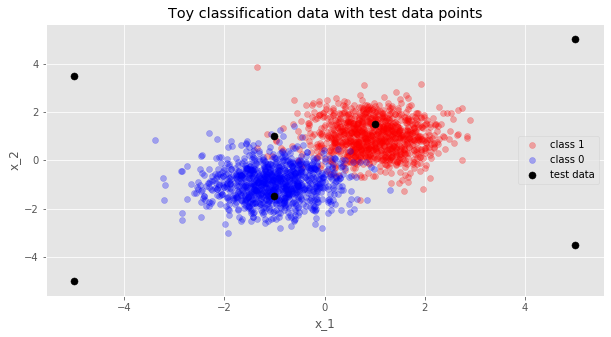

In [82]:
# Visualize our test data points
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(x[y == 1, 0], x[y == 1, 1], alpha=0.3, color='red', label='class 1')
ax.scatter(x[y == 0, 0], x[y == 0, 1], alpha=0.3, color='blue', label='class 0')
for i in range(len(test_points)):
    pt = test_points[i]
    if i == 0:
        ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black', label='test data')
    else:
        ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black')
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.set_title('Toy classification data with test data points')
ax.legend(loc='best')
plt.show()

## Initial Neural Network Training

In [181]:
bayes_iters = 10
batch_size = 256
num_classes = 2
epochs = 10

In [182]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

x_train shape: (1600, 2)
x_test shape: (400, 2)


In [183]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [184]:
input_shape = x_train.shape[1]
input_shape

2

In [185]:
def get_dropout(input_tensor, p=0.5, mc=False):
    if mc:
        return Dropout(p)(input_tensor, training=True)
    else:
        return Dropout(p)(input_tensor, training=False)


def get_model(mc=False, p=0.5, act="relu"):
    inp = Input(shape=(input_shape,))
    x = Dense(128, activation=act)(inp)
    x = Dense(64, activation=act)(x)
    x = get_dropout(x, p=p, mc=mc)
    out = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inp, outputs=out)

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    return model

In [186]:
model = get_model(mc=False, act="relu")


In [187]:
model.summary()

Model: "model_132"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_137 (InputLayer)       (None, 2)                 0         
_________________________________________________________________
dense_408 (Dense)            (None, 128)               384       
_________________________________________________________________
dense_409 (Dense)            (None, 64)                8256      
_________________________________________________________________
dropout_134 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_410 (Dense)            (None, 2)                 130       
Total params: 8,770
Trainable params: 8,770
Non-trainable params: 0
_________________________________________________________________


In [188]:
h = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))

Train on 1600 samples, validate on 400 samples
Epoch 1/10
1600/1600 [==============================] - 0s 185us/step - loss: 0.5701 - accuracy: 0.8056 - val_loss: 0.3821 - val_accuracy: 0.9750
Epoch 2/10
1600/1600 [==============================] - 0s 8us/step - loss: 0.3039 - accuracy: 0.9725 - val_loss: 0.2073 - val_accuracy: 0.9800
Epoch 3/10
1600/1600 [==============================] - 0s 9us/step - loss: 0.1728 - accuracy: 0.9762 - val_loss: 0.1314 - val_accuracy: 0.9775
Epoch 4/10
1600/1600 [==============================] - 0s 9us/step - loss: 0.1189 - accuracy: 0.9756 - val_loss: 0.0966 - val_accuracy: 0.9775
Epoch 5/10
1600/1600 [==============================] - 0s 9us/step - loss: 0.0944 - accuracy: 0.9750 - val_loss: 0.0790 - val_accuracy: 0.9775
Epoch 6/10
1600/1600 [==============================] - 0s 9us/step - loss: 0.0821 - accuracy: 0.9750 - val_loss: 0.0692 - val_accuracy: 0.9800
Epoch 7/10
1600/1600 [==============================] - 0s 9us/step - loss: 0.0754 - ac

In [91]:
model.save_weights('initial_model_weights.h5')

## Deep Ensemble with Bootstrap

In [202]:
ensembles = 10
ens_test_probs = []

for i in range(ensembles):
    bootstrap_x, bootstrap_y = resample(x,y, random_state=0)
    bootstrap_y = keras.utils.to_categorical(bootstrap_y, num_classes)
    
    # Fit neural network model
    nn = model.fit(bootstrap_x, bootstrap_y,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=0,
                    validation_data=(x_test, y_test))
    
    # Accuracy of model
    score = model.evaluate(x_test, y_test, verbose=0)
    #print('Test loss:', np.round(score[0],2))
    print()
    
    print("Iteration: " + str(i+1) +' Test accuracy:'+ str(np.round(score[1],2)))
        
    #Predictions & uncertainty for test points
    prob = model.predict(np.array(test_points))
    ens_test_probs.append(prob)



Iteration: 1 Test accuracy:0.98

Iteration: 2 Test accuracy:0.98

Iteration: 3 Test accuracy:0.98

Iteration: 4 Test accuracy:0.98

Iteration: 5 Test accuracy:0.98

Iteration: 6 Test accuracy:0.98

Iteration: 7 Test accuracy:0.98

Iteration: 8 Test accuracy:0.98

Iteration: 9 Test accuracy:0.98

Iteration: 10 Test accuracy:0.98


In [203]:
ens_variance = np.std(np.array(ens_test_probs),axis=0)**2

for i in range(len(test_points)):
    print("Epistemic uncertainty for test point: " + str(test_points[i]) + " : " + str(np.round(ens_variance[i][0],3)))

Epistemic uncertainty for test point: (-5, -5) : 0.0
Epistemic uncertainty for test point: (-5, 3.5) : 0.05
Epistemic uncertainty for test point: (5, 5) : 0.0
Epistemic uncertainty for test point: (5, -3.5) : 0.001
Epistemic uncertainty for test point: (-1, 1) : 0.006
Epistemic uncertainty for test point: (-1, -1.5) : 0.0
Epistemic uncertainty for test point: (1, 1.5) : 0.0


## Bayesian Dropout Subsampling

In [160]:
dropout_post_predictions = []
test_probs = []

for i in range(bayes_iters):
    print()
    #Generate random p value for Dropout ratio
    p_rand = np.random.random()
    print("Iteration: " + str(i+1) + " Random p: " + str(np.round(p_rand,2)))
    drop_model = get_model(mc=True, p= p_rand, act="relu")
    
    #Initialize model with pre-trained weights
    drop_model.load_weights('initial_model_weights.h5')
    h_mc = drop_model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=0,
                        validation_data=(x_test, y_test))
    # Accuracy of model
    score = drop_model.evaluate(x_test, y_test, verbose=0)
    #print('Test loss:', np.round(score[0],2))
    print('Test accuracy:', np.round(score[1],2))
    
    #Posterior predictions
    y_pred = drop_model.predict(x_test)
    dropout_post_predictions.append(y_pred)
    
    #Predictions & uncertainty for test points
    prob = drop_model.predict(np.array(test_points))
    test_probs.append(prob)



Iteration: 1 Random p: 0.99
Test accuracy: 0.6

Iteration: 2 Random p: 0.07
Test accuracy: 0.97

Iteration: 3 Random p: 0.52
Test accuracy: 0.97

Iteration: 4 Random p: 0.32
Test accuracy: 0.97

Iteration: 5 Random p: 0.81
Test accuracy: 0.97

Iteration: 6 Random p: 0.2
Test accuracy: 0.97

Iteration: 7 Random p: 0.94
Test accuracy: 0.88

Iteration: 8 Random p: 0.44
Test accuracy: 0.96

Iteration: 9 Random p: 0.86
Test accuracy: 0.96

Iteration: 10 Random p: 0.37
Test accuracy: 0.97


In [161]:
np.array(test_probs).shape

(10, 7, 2)

In [162]:
posterior_mean_preds = np.mean(np.array(test_probs),axis=0)
posterior_mean_preds.shape

(7, 2)

In [164]:
drop_variance = np.std(np.array(test_probs),axis=0)**2

for i in range(len(test_points)):
    print("Epistemic uncertainty for test point: " + str(test_points[i]) + " : " + str(np.round(drop_variance[i][0],3)))

Epistemic uncertainty for test point: (-5, -5) : 0.021
Epistemic uncertainty for test point: (-5, 3.5) : 0.058
Epistemic uncertainty for test point: (5, 5) : 0.044
Epistemic uncertainty for test point: (5, -3.5) : 0.059
Epistemic uncertainty for test point: (-1, 1) : 0.02
Epistemic uncertainty for test point: (-1, -1.5) : 0.021
Epistemic uncertainty for test point: (1, 1.5) : 0.0
